In [1]:
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from fedlab.utils.dataset.partition import FMNISTPartitioner

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f'{device} is available')

mps is available


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [4]:
dataset_path = os.path.join("path_to_data")
trainset = torchvision.datasets.FashionMNIST(root=dataset_path, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=dataset_path, train=False, download=True, transform=transform)

In [5]:
num_clients = 100
seed = 2021
alpha_values = [0.1, 0.3, 1.0, 5.0, 10.0]

partitions = {}
for alpha in alpha_values:
    partitions[f"Dirichlet_alpha_{alpha}"] = FMNISTPartitioner(
        trainset.targets,
        num_clients=num_clients,
        partition="noniid-labeldir",
        dir_alpha=alpha,
        seed=seed,
    )

In [6]:
# Define Model (Simple CNN)
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 14 * 14, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_on_worker(model, dataloader, device="cpu"):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Ensure the output and labels batch sizes match
        assert outputs.size(0) == labels.size(0), f"Output batch size mismatch: {outputs.size(0)} vs {labels.size(0)}"
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return {k: v.clone() for k, v in model.state_dict().items()}

In [8]:
def aggregate_updates(updates):
    """
    Averages updates for global aggregation.
    """
    return {k: torch.mean(torch.stack([u[k] for u in updates]), dim=0) for k in updates[0]}

def full_trim(update, fraction):
    """
    Applies a full-trim attack to a model update.
    """
    for key, param in update.items():
        k = int(param.numel() * fraction)
        flat = param.view(-1)
        flat[torch.topk(flat.abs(), k=k, largest=False).indices] = 0
        param.copy_(flat.view_as(param))
    return update

In [9]:
def evaluate_model(model, dataloader, device="cpu"):
    """
    Evaluates the model on the test set.
    """
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

In [10]:
attack_fraction = 0.4
results = []
Epochs = 15

for alpha, partition in partitions.items():
    print(f"Running simulations for {alpha}...")
    client_indices = partition.client_dict
    workers = {
        i: DataLoader(Subset(trainset, indices), batch_size=32, shuffle=True)
        for i, indices in client_indices.items()
    }
    test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    normal_accuracies = []
    attack_accuracies = []

    for attack in [False, True]:
        mode = "Attack" if attack else "No Attack"
        print(f"  Running mode: {mode}")
        model = SimpleCNN()
        for _ in range(Epochs):
            updates = []
            for i, loader in workers.items():
                local_update = train_on_worker(model, loader, device)
                if attack and random.random() < attack_fraction:
                    local_update = full_trim(local_update, 0.6)
                updates.append(local_update)

            aggregated_update = aggregate_updates(updates)
            model.load_state_dict(aggregated_update)

        acc = evaluate_model(model, test_loader, device)
        print(f"    Accuracy: {acc:.4f}")
        if attack:
            attack_accuracies.append(acc)
        else:
            normal_accuracies.append(acc)

    alpha_value = alpha if isinstance(alpha, float) else alpha.split('_')[2]
    results.append({
        "Alpha": alpha_value,
        "Normal Accuracy": np.mean(normal_accuracies),
        "Attack Accuracy": np.mean(attack_accuracies),
    })

Running simulations for Dirichlet_alpha_0.1...
  Running mode: No Attack
    Accuracy: 83.3300
  Running mode: Attack
    Accuracy: 80.9800
Running simulations for Dirichlet_alpha_0.3...
  Running mode: No Attack
    Accuracy: 86.5900
  Running mode: Attack
    Accuracy: 84.4300
Running simulations for Dirichlet_alpha_1.0...
  Running mode: No Attack
    Accuracy: 88.0200
  Running mode: Attack
    Accuracy: 86.2300
Running simulations for Dirichlet_alpha_5.0...
  Running mode: No Attack
    Accuracy: 88.2000
  Running mode: Attack
    Accuracy: 86.6500
Running simulations for Dirichlet_alpha_10.0...
  Running mode: No Attack
    Accuracy: 88.1900
  Running mode: Attack
    Accuracy: 86.6200


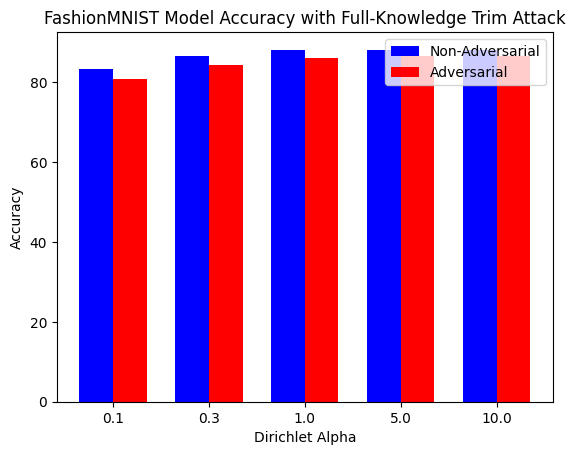

In [ ]:
results_df = pd.DataFrame(results)

bar_width = 0.35
alphas = results_df["Alpha"]
positions = np.arange(len(alphas))

plt.bar(positions - bar_width / 2, results_df["Normal Accuracy"], bar_width, label="Non-Adversarial", color='b')
plt.bar(positions + bar_width / 2, results_df["Attack Accuracy"], bar_width, label="Adversarial", color='r')

plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy")
plt.title("FashionMNIST Model Accuracy with Full-Knowledge Trim Attack")
plt.xticks(positions, alphas)
plt.legend()

plt.savefig("FMNIST_FKTA_Results.png")
plt.show()